In [3]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import math
from tqdm import tqdm

from simulation_gaussian import run_gaussian_experiment
from simulation_ssl import run_ssl_experiment

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams["axes.labelsize"] = 23
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 28
# mpl.rcParams['text.usetex'] = True # comment out this line if the machine does not have TeX installed
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [5]:
d = 2
seeds = torch.arange(10)

props = torch.load(f"output/props_{d}.pt")
Is = torch.stack([torch.load(f"output/mutual_info_{d}_seed_{seed}.pt") for seed in seeds])
acc1s = torch.stack([torch.load(f"output/bayes_accuracies_{d}_seed_{seed}.pt") for seed in seeds])
acc2s = torch.stack([torch.load(f"output/two_stage_accuracies_{d}_seed_{seed}.pt") for seed in seeds])
acc3s = torch.stack([torch.load(f"output/clip_accuracies_{d}_seed_{seed}.pt") for seed in seeds])

In [9]:
# print(acc1s)
# print(acc2s)
# print(acc1s-acc2s)
# print(Is)

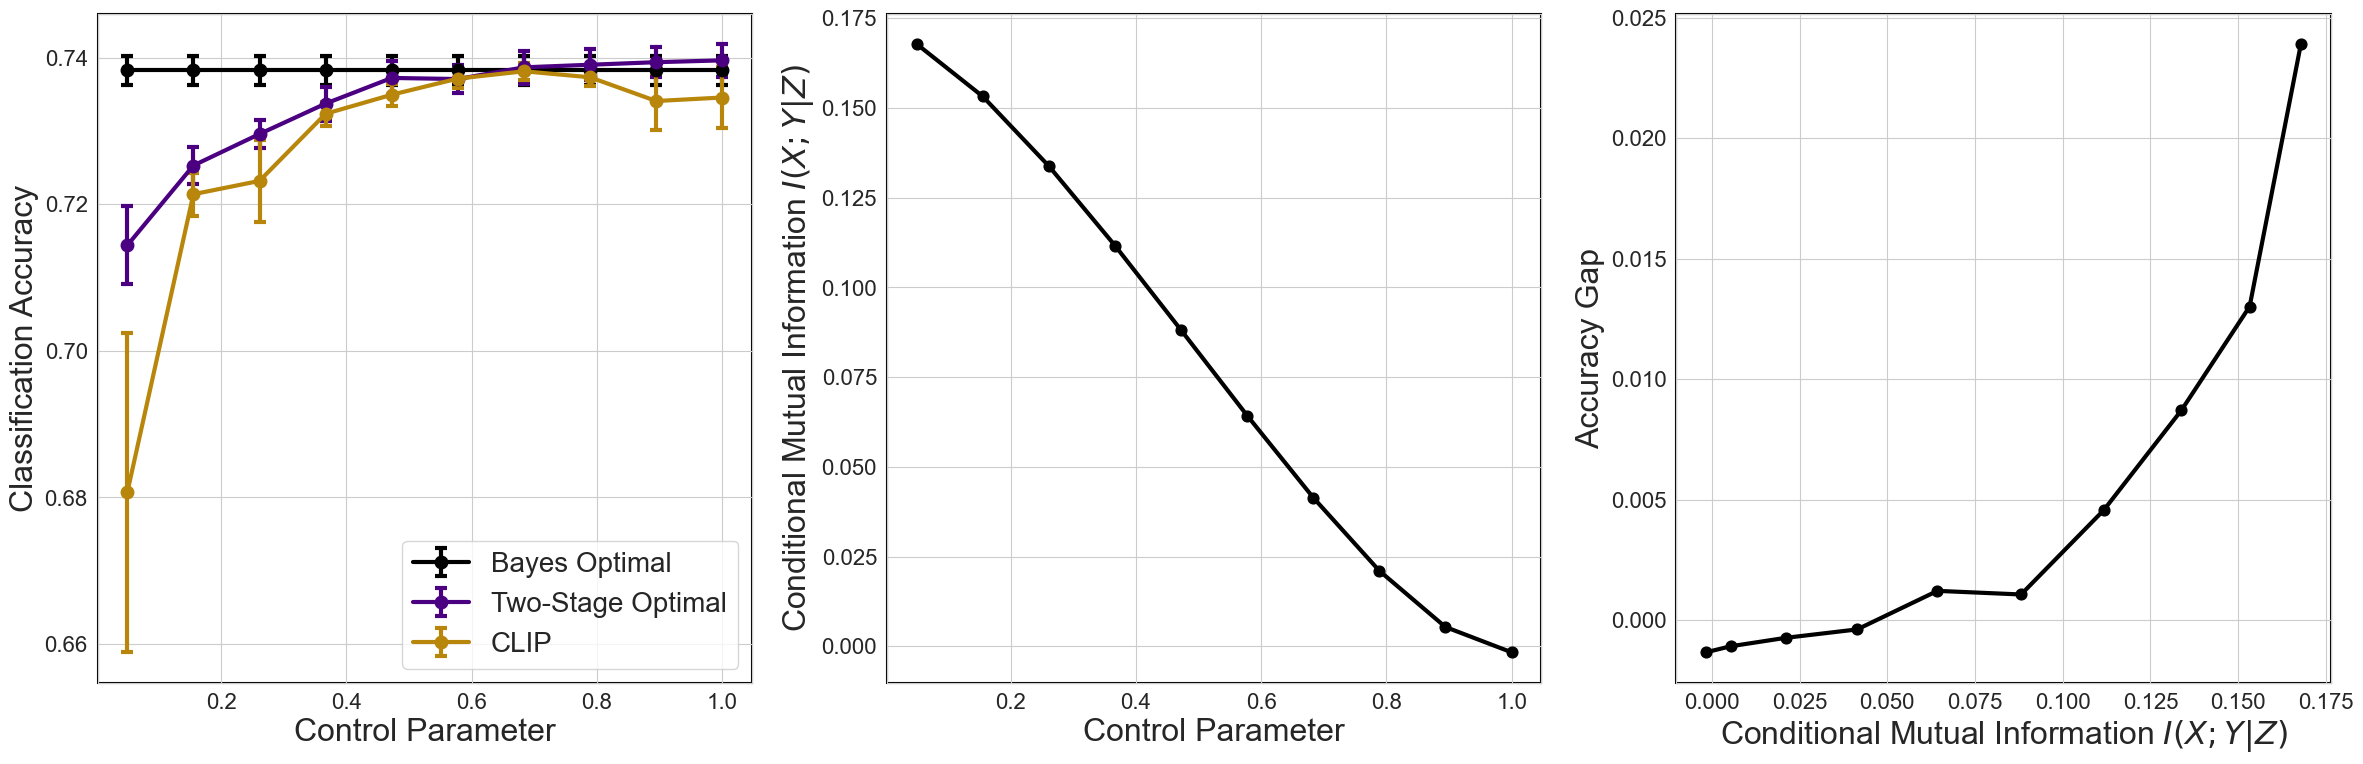

In [9]:
sns.set_style("whitegrid")

pscale = 8
s = 60
color1 = "black"
color2 = "indigo"
color3 = "darkgoldenrod"

linewidth = 3
elinewidth = 2
capsize = 4
s_scale = 0.3

fig, ax = plt.subplots(1, 3, figsize=(3 * pscale, pscale))


zscore = 0.96
points = props
# ax[0].plt(points, acc1s.mean(dim=0), label="Bayes Optimal", color="gray")
ax[0].errorbar(
        points, 
        acc1s.mean(dim=0), 
        # yerr=zscore * acc1s.std(axis=1), 
        yerr=acc1s.std(dim=0) / math.sqrt(len(seeds)), 
        color=color1, 
        linewidth=linewidth, 
        elinewidth=linewidth,
        capsize=capsize,
        capthick=linewidth,
        fmt=".-",
        markersize=s_scale * s,
        label="Bayes Optimal"
    )

# ax[0].plot(points, acc2s.mean(dim=0), label="Two-Stage Optimal", color="tab:blue")
ax[0].errorbar(
        points, 
        acc2s.mean(dim=0), 
        # yerr=zscore * acc2s.std(axis=1), 
        yerr=acc2s.std(dim=0) / math.sqrt(len(seeds)),
        color=color2, 
        linewidth=linewidth, 
        elinewidth=linewidth,
        capsize=capsize,
        capthick=linewidth,
        fmt=".-",
        markersize=s_scale * s,
        label="Two-Stage Optimal"
    )

# ax[0].plot(points, acc3s, label="CLIP", color="tab:red")
ax[0].errorbar(
        points, 
        acc3s.mean(dim=0), 
        # yerr=zscore * acc2s.std(axis=1), 
        yerr=acc3s.std(dim=0) / math.sqrt(len(seeds)),
        color=color3, 
        linewidth=linewidth, 
        elinewidth=linewidth,
        capsize=capsize,
        capthick=linewidth,
        fmt=".-",
        markersize=s_scale * s,
        label="CLIP"
    )


ax[0].legend(loc = "lower right")
ax[1].scatter(points, Is.mean(dim=0), color="k", s=s)
ax[1].plot(points, Is.mean(dim=0), color="k")

ax[0].set_ylabel("Classification Accuracy")
ax[1].set_ylabel(r"Conditional Mutual Information $I(X;Y|Z)$")

ax[0].set_xlabel("Control Parameter")
ax[1].set_xlabel("Control Parameter")

ax[2].scatter(Is.mean(dim=0), (acc1s - acc2s).mean(dim=0), color="k", s=s)
ax[2].plot(Is.mean(dim=0), (acc1s - acc2s).mean(dim=0), color="k")
ax[2].set_xlabel(r"Conditional Mutual Information $I(X;Y|Z)$")
ax[2].set_ylabel("Accuracy Gap")


# ax[2].set_xscale("log")
# ax[2].set_yscale("log")

for ax_ in ax:
    ax_.patch.set_edgecolor('black')  
    ax_.patch.set_linewidth(1.5)

fig.tight_layout(pad=2)